In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

In [ ]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteUR5KWU/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
#Preprocess the images and create batches before feeding it to our model
def augment_images(image, label):
  
  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)

In [ ]:
#Build the classifier
model = Sequential()
model.add(Conv2D(16,input_shape=(300,300,3),kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)       7

In [ ]:
# Training will take around 30 minutes to complete using a GPU. Time for a break!

model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.RMSprop(lr=0.001))
model.fit(train_batches,epochs=25)

Epoch 1/25
582/582 [==============================] - 102s 117ms/step - loss: 0.6837 - accuracy: 0.5569
Epoch 2/25
582/582 [==============================] - 68s 114ms/step - loss: 0.6487 - accuracy: 0.6266
Epoch 3/25
582/582 [==============================] - 68s 114ms/step - loss: 0.6123 - accuracy: 0.6695
Epoch 4/25
582/582 [==============================] - 68s 114ms/step - loss: 0.5916 - accuracy: 0.6993
Epoch 5/25
582/582 [==============================] - 68s 114ms/step - loss: 0.5752 - accuracy: 0.7097
Epoch 6/25
582/582 [==============================] - 68s 114ms/step - loss: 0.5632 - accuracy: 0.7180
Epoch 7/25
582/582 [==============================] - 68s 114ms/step - loss: 0.5480 - accuracy: 0.7291
Epoch 8/25
582/582 [==============================] - 68s 114ms/step - loss: 0.5446 - accuracy: 0.7373
Epoch 9/25
582/582 [==============================] - 68s 114ms/step - loss: 0.5341 - accuracy: 0.7422
Epoch 10/25
582/582 [==============================] - 68s 114ms/step - 

In [ ]:
#Building the CAM model
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0     

In [ ]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/37, 300/37, 1), order=2)
  
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()


In [ ]:
#Testing
!wget -O cat1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
!wget -O cat2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
!wget -O catanddog.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/catanddog.jpg
!wget -O dog1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg
!wget -O dog2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog2.jpg

sigmoid output: [[0.00888771]]
prediction: cat


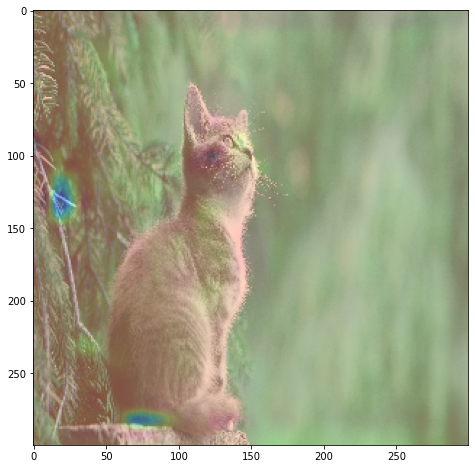

sigmoid output: [[9.976683e-05]]
prediction: cat


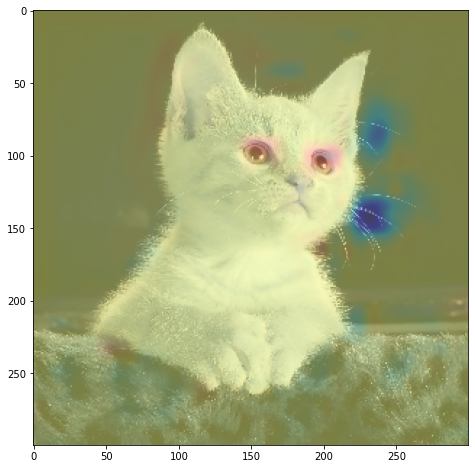

sigmoid output: [[0.26179358]]
prediction: cat


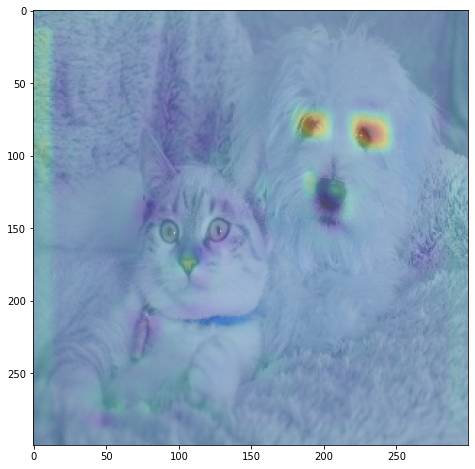

sigmoid output: [[0.47002238]]
prediction: cat


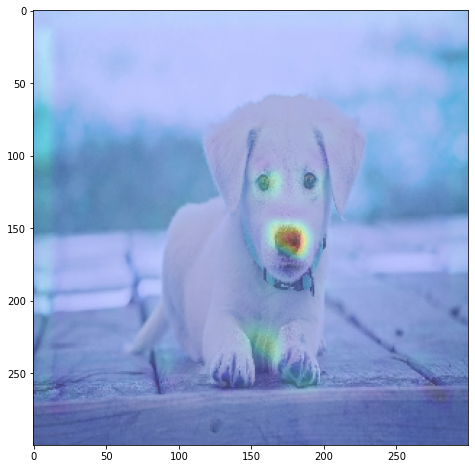

sigmoid output: [[0.16745704]]
prediction: cat


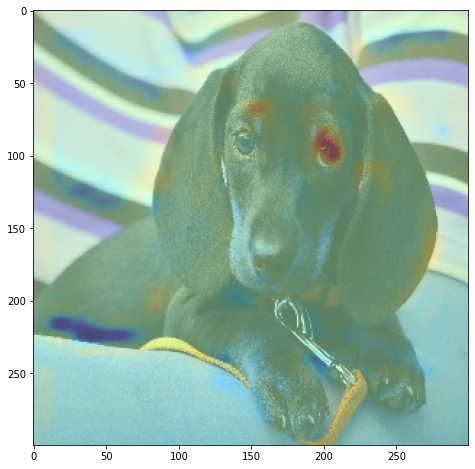

In [ ]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')

ground truth: cat
sigmoid output: [[0.14045413]]
prediction: cat


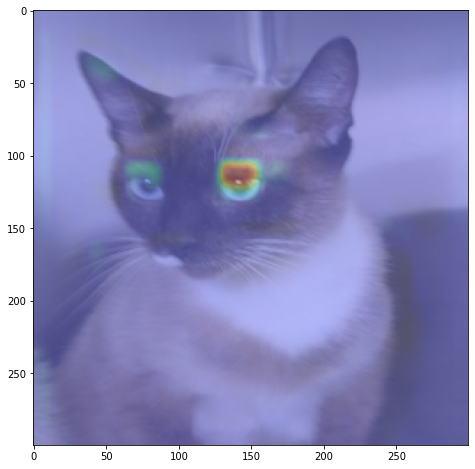

ground truth: dog
sigmoid output: [[0.20859921]]
prediction: cat


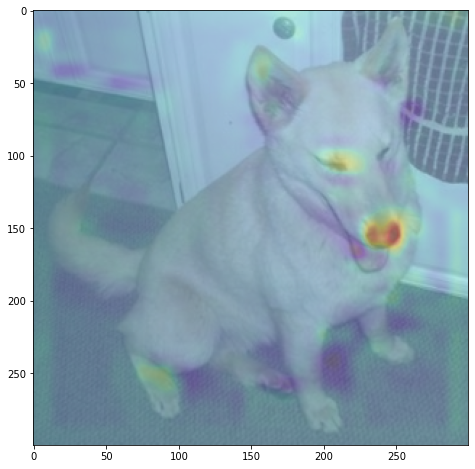

ground truth: dog
sigmoid output: [[0.05608726]]
prediction: cat


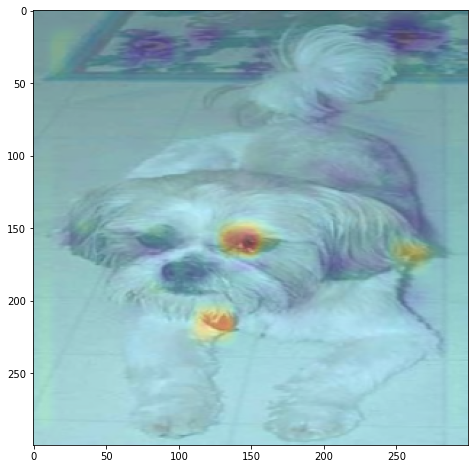

ground truth: cat
sigmoid output: [[0.00260437]]
prediction: cat


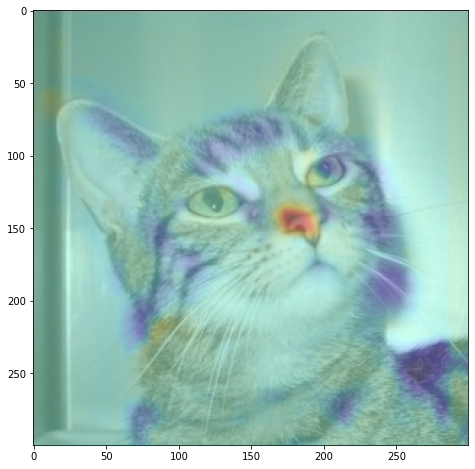

ground truth: cat
sigmoid output: [[0.06727893]]
prediction: cat


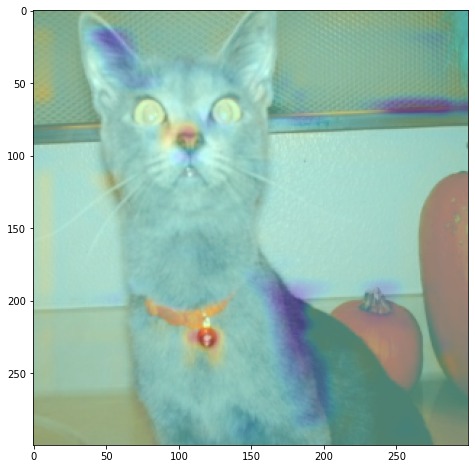

In [ ]:
# preprocess the test images
augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.batch(1)


for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results)

If your training reached 80% accuracy, you may notice from the images above that the presence of eyes and nose play a big part in determining a dog, while whiskers and a colar mostly point to a cat. Some can be misclassified based on the presence or absence of these features. This tells us that the model is not yet performing optimally and we need to tweak our process (e.g. add more data, train longer, use a different model, etc).